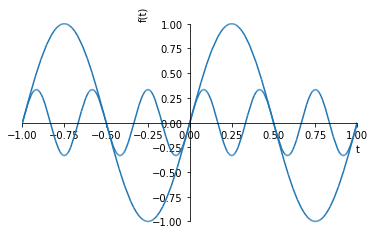

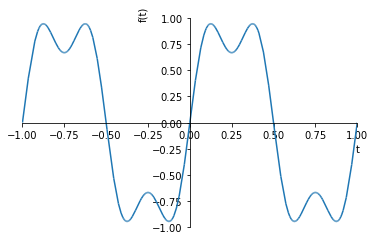

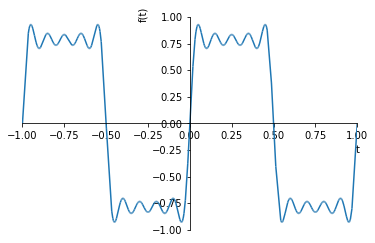

In [2]:
import sympy as sp

t = sp.Symbol('t')
sp.plot(sp.sin(2*sp.pi*t), sp.sin(2*sp.pi*t*3)/3, (t,-1,1))
sp.plot(sp.sin(2*sp.pi*t) + sp.sin(2*sp.pi*t*3)/3, (t,-1,1))
sp.plot(sp.sin(2*sp.pi*t) + sp.sin(2*sp.pi*t*3)/3 + sp.sin(2*sp.pi*t*5)/5 + sp.sin(2*sp.pi*t*7)/7 + sp.sin(2*sp.pi*t*9)/9, (t,-1,1))

In [6]:
# Cálculo da DFT
import numpy as np

def DFT(N,M,f):
    F = np.zeros(2*M,'complex')
    for k in range(-M,M):
        for x in range(N):
            F[k] += f[x] * np.exp(-1j*(2*np.pi/N)*k*x)
    F = F / N
    norm = np.absolute(F)
    print(np.arange(-M,M)[norm > 0.9*np.max(norm)])
    plt.bar(np.arange(-M,M),norm); plt.show()

N = 30
M = 2*N # range para cálculo de F[k]: [-M,M]
DFT(N,M,np.cos((2*np.pi/N)*np.arange(N)))
DFT(N,M,np.sin((2*np.pi/N)*np.arange(N)))
DFT(N,M,cv2.getGaussianKernel(N,2))
DFT(N,M,cv2.getGaussianKernel(N,10))
f = np.zeros(N); f[0] = 1; DFT(N,M,f) # pulso no 0
f = np.zeros(N); f[0:4] = 1; DFT(N,M,f) # quadrada em [10,20] -> efeito "ring"

########

# DFT em 2 dimensões no OpenCV

n = 50

wx = 2 * np.pi / n * 2 # 2 ciclos por imagem (eixo x)
wy = 2 * np.pi / n * 3 # 3 ciclos por imagem (eixo y)
img1 = np.zeros((n,n))
for x in range(n):
    for y in range(n):
        img1[x,y] = np.sin(wx*x + wy*y)
plot_magnitude_spectrum(img1)

wx = 2 * np.pi / n * 5
wy = 2 * np.pi / n * 1
img2 = np.zeros((n,n))
for x in range(n):
    for y in range(n):
        img2[x,y] = np.sin(wx*x + wy*y)
plot_magnitude_spectrum(img2)

plot_magnitude_spectrum(img1 + img2);

[-59 -31 -29  -1   1  29  31  59]


NameError: name 'plt' is not defined

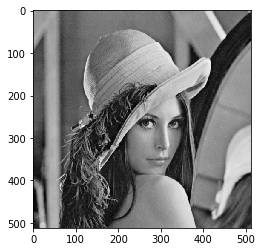

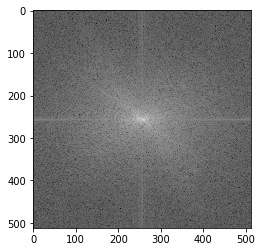

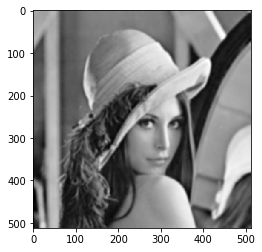

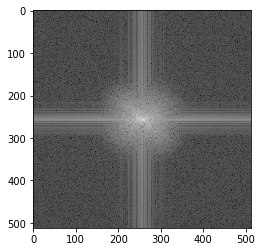

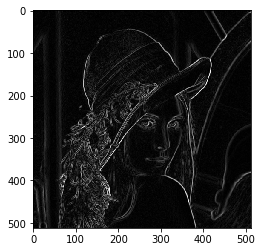

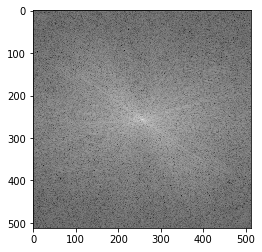

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def plot_magnitude_spectrum(img):
    plt.imshow(img,'gray'); plt.show()
    dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
    dft = np.fft.fftshift(dft) # coloca origem no centro da imagem (ao invés do canto superior esquerdo)
    mag = np.log(cv2.magnitude(dft[:,:,0],dft[:,:,1])+1e-6) # log facilita visualização: decaimento exponencial
    plt.imshow(mag,'gray'); plt.show()
    return dft

img = cv2.imread('images/lena.png',0)
plot_magnitude_spectrum(img)

img2 = cv2.GaussianBlur(img, (11,11), 0)
plot_magnitude_spectrum(img2)

img2 = cv2.magnitude(cv2.Sobel(img,cv2.CV_64F,1,0), cv2.Sobel(img,cv2.CV_64F,0,1))
plot_magnitude_spectrum(img2);

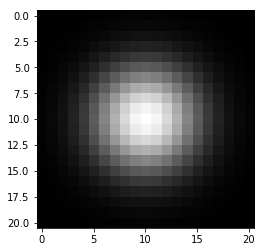

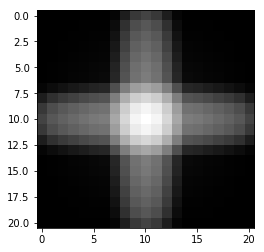

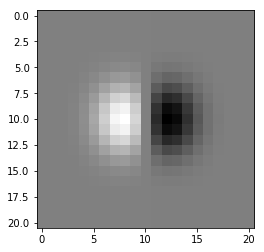

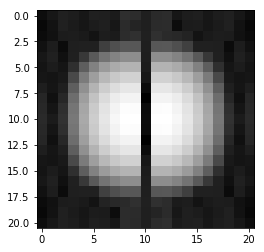

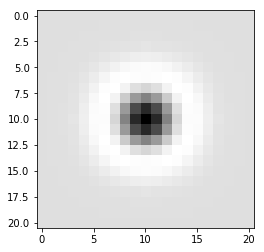

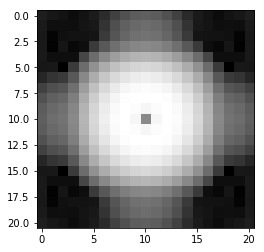

In [7]:
# Análise do espectro de frequência dos filtros gaussiano, sobel(x) e laplaciano

n = 21

h1D = cv2.getGaussianKernel(n, 0) # sigma=1.5 obtido empiricamente
gauss = np.outer(h1D,h1D)
plot_magnitude_spectrum(gauss)

impulse = np.zeros((n,n)); impulse[n//2,n//2]=1

sobelx = cv2.Sobel(impulse, cv2.CV_64F, 1, 0, ksize=n, borderType=cv2.BORDER_CONSTANT)
plot_magnitude_spectrum(sobelx) # lembre que a máxima frequência é N/2 (não está descandando freq. altas)
                                # descarta freq. baixas na direção x, e freq. altas e baixas na dir. y

laplacian = cv2.Laplacian(impulse,cv2.CV_64F,ksize=n)
plot_magnitude_spectrum(laplacian);

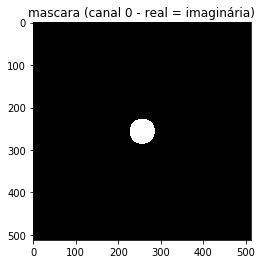

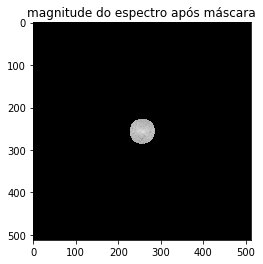

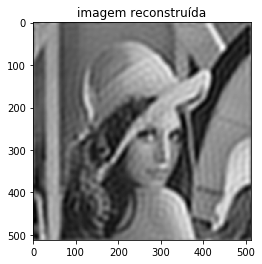

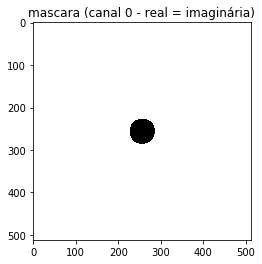

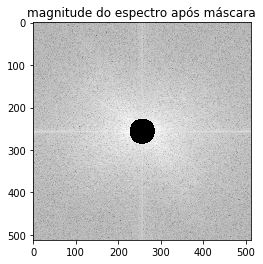

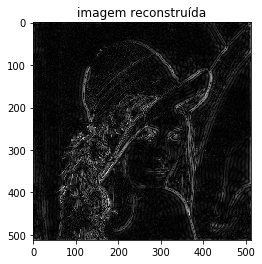

In [222]:
# Reconstrução da imagem descartando frequências altas e baixas

img = cv2.imread('images/lena.png',0)

# gera a máscara (tem 2 canais, pois será aplicado no espectro)
rows, cols = img.shape
mask = np.zeros((rows,cols,2),np.uint8)
#mask[rows//2-30:rows//2+30, cols//2-30:cols//2+30] = 1 # máscara quadrada
cv2.circle(mask, (rows//2,cols//2), 30, (255,255,255), -1, 8,0);
plt.imshow(mask[:,:,0],'gray'); plt.title('mascara (canal 0 - real = imaginária)'); plt.show()

# calcula DFT
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# aplica máscara no espectro e calcula magnitude
fshift = dft_shift * mask
magnitude_spectrum = np.log(cv2.magnitude(fshift[:,:,0],fshift[:,:,1])+1) # log facilita visualização: decaimento exponencial
plt.imshow(magnitude_spectrum,'gray'); plt.title('magnitude do espectro após máscara'); plt.show()

# reconstrói a imagem
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
plt.imshow(img_back,'gray'); plt.title('imagem reconstruída'); plt.show()
# observe os 'rings' (seriam removidos com as frequências mais altas - lembre da aproximação do sinal quadrado)


## Inversão da máscara: remove frequências baixas
mask = 255 - mask # inverte a máscara
plt.imshow(mask[:,:,0],'gray'); plt.title('mascara (canal 0 - real = imaginária)'); plt.show()

# calcula DFT
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# aplica máscara no espectro e calcula magnitude
fshift = dft_shift * mask
magnitude_spectrum = np.log(cv2.magnitude(fshift[:,:,0],fshift[:,:,1])+1) # log facilita visualização: decaimento exponencial
plt.imshow(magnitude_spectrum,'gray'); plt.title('magnitude do espectro após máscara'); plt.show()

# reconstrói a imagem
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
plt.imshow(img_back,'gray'); plt.title('imagem reconstruída'); plt.show()

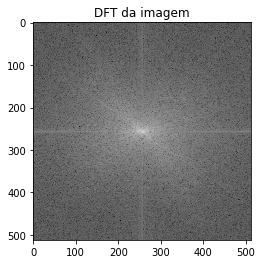

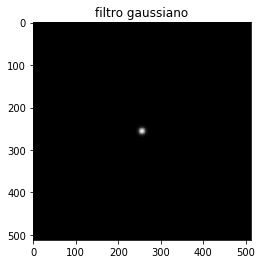

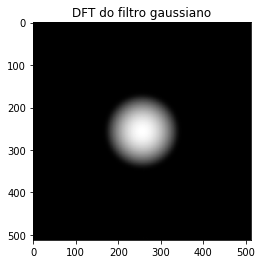

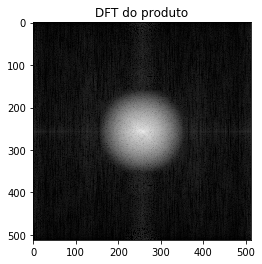

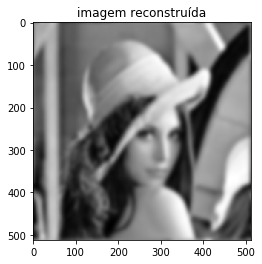

In [46]:
# Convolução usando produto de Transformadas de Fourier

# DFT da imagem
img = cv2.imread('images/lena.png',0)
dft_img = np.fft.fftshift( cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT) )
plt.imshow(np.log(cv2.magnitude(dft_img[:,:,0],dft_img[:,:,1])),'gray'); plt.title('DFT da imagem'); plt.show()

# DFT do filtro gaussiano
gx = cv2.getGaussianKernel(img.shape[0], 5)
gy = cv2.getGaussianKernel(img.shape[1], 5)
gauss = np.outer(gx,gy)
plt.imshow(gauss,'gray'); plt.title('filtro gaussiano'); plt.show()
dft_gauss = np.fft.fftshift( cv2.dft(np.float32(gauss),flags = cv2.DFT_COMPLEX_OUTPUT) )
plt.imshow(np.log(cv2.magnitude(dft_gauss[:,:,0],dft_gauss[:,:,1])+1e-6),'gray'); plt.title('DFT do filtro gaussiano'); plt.show()

# Multiplicação do DFT da imagem com o DFT do filtro gaussiano (multiplcação de números complexos)
dft = np.zeros((img.shape[0],img.shape[1],2))
dft[:,:,0] = dft_img[:,:,0]*dft_gauss[:,:,0] - dft_img[:,:,1]*dft_gauss[:,:,1] # real
dft[:,:,1] = dft_img[:,:,0]*dft_gauss[:,:,1] + dft_img[:,:,1]*dft_gauss[:,:,0] # imaginário
#dft = dft_img * dft_gauss # veja o efeito de multiplicar como número real
plt.imshow(np.log(cv2.magnitude(dft[:,:,0],dft[:,:,1])+1e-6),'gray'); plt.title('DFT do produto'); plt.show()

# Imprime imagem resultante
img_back = np.flip(np.flip(np.fft.ifftshift(cv2.idft(dft)), 0), 1)
img_back_mag = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
plt.imshow(img_back_mag,'gray'); plt.title('imagem reconstruída'); plt.show()

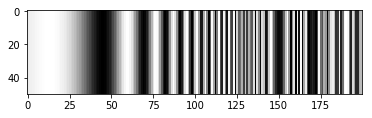

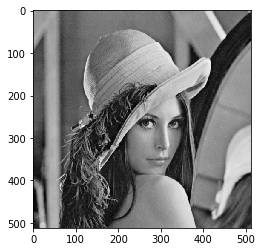

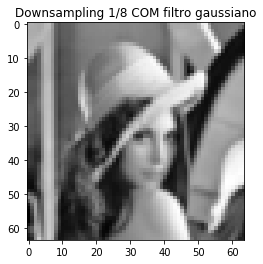

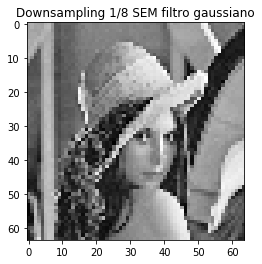

In [261]:
# Aliasing

n, m = 50, 200
img = np.zeros((n,m))
for x in range(n):
    for y in range(m):
        img[x,y] = np.sin(2**float(y/20))
plt.imshow(img,'gray'); plt.show()

# Downsampling imagens com filtro gaussiano (redução de aliasing)
lena = cv2.imread('images/lena.png',0)
plt.imshow(lena,'gray'); plt.show()
lena1 = cv2.pyrDown(lena)
lena2 = cv2.pyrDown(lena1)
lena3 = cv2.pyrDown(lena2)
plt.imshow(lena3,'gray'); plt.title('Downsampling 1/8 COM filtro gaussiano'); plt.show()

img = np.zeros((lena.shape[0]//8, lena.shape[1]//8))
for i in range(lena.shape[0]//8):
    for j in range(lena.shape[1]//8):
        img[i,j] = lena[8*i,8*j]
plt.imshow(img,'gray'); plt.title('Downsampling 1/8 SEM filtro gaussiano'); plt.show()

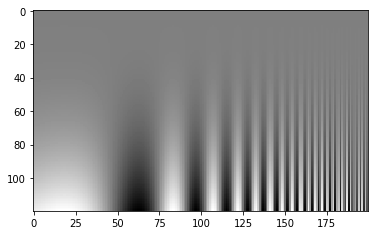

In [282]:
# Sensibilidade a contraste em frequências altas e baixas
n, m = 120, 200
img = np.zeros((n,m))
for x in range(n):
    for y in range(m):
        img[x,y] = x**3 * np.sin(2**float(y/28))
plt.imshow(img,'gray'); plt.show()

### 2C-L1 26-29,34,40: Complementos matemáticos

### Identidades trigonométricas:
$$\sin(a) \sin(b) = \frac{\cos(a-b) - \cos(a+b)}{2}$$
$$\cos(a) \cos(b) = \frac{\cos(a+b) + \cos(a-b)}{2}$$
$$\sin(a) \cos(b) = \frac{\sin(a+b) + \sin(a-b)}{2}$$
$$\sin(-a) = -\sin(a)$$
$$\cos(-a) = \cos(a)$$
$$\sin(a) = \cos(a-\pi/2)$$
$$\sin(a+b) = \sin(a)\cos(b) + \sin(b)\cos(a)$$
$$\cos(a+b) = \cos(a)\cos(b) - \sin(a)\sin(b)$$


### Slide 26-28

Integral do produto de senóides. Seja $T = 1/\omega$, $a$ e $b$ inteiros.
$$\begin{align*}
\int_{t}^{t+T} \sin(a\omega x+\phi) \sin(b\omega x+\psi) dx 
&= \frac{1}{2} \int_{t}^{t+T} [\cos((a-b)\omega x+\phi-\psi) - \cos((a+b)\omega x+\phi+\psi)] dx \\
&= \frac{1}{2} \int_{t}^{t+T} \cos((a-b)\omega x+\phi-\psi) dx - \frac{1}{2} \int_{t}^{t+T} \cos((a+b)\omega x+\phi+\psi) dx \\
&= \begin{cases} \frac{1}{2} (0 - 0) = 0,& a \neq b \text{ e } a \neq -b\\ \frac{1}{2} \left( \int_{t}^{t+T} \cos(\phi-\psi) dx - 0\right) = \frac{T}{2} \cos(\phi-\psi),& a = b \\ \frac{1}{2} \left( 0 - \int_{t}^{t+T} \cos(\phi+\psi) dx \right) = -\frac{T}{2} \cos(\phi+\psi),& a = -b. \end{cases}
\end{align*}$$

- $\int_{t}^{t+T} \cos(k\omega x+\theta) dx = 0$ para qualquer $k$ inteiro não nulo, pois em um intervalo de $T$ unidades temos $k$ ciclos completos.
- Quando as duas são senos sem defasagem, a expressão vale $T/2$ quando $a=b$, e $-T/2$ quando $a=-b$.
- Quando as duas são cossenos sem defasagem ($\phi=\psi=\pi/2$), a expressão vale $T/2$ quando $a=b$ ou $a=-b$.
- Quando uma é seno e outra cosseno, ambas sem defasagem ($\phi = \pi/2$ e $\psi=0$ ou $\phi=0$ e $\psi=\pi/2$), a expressão sempre vale zero.

Qualquer defasagem pode ser obtida pela soma ponderada se senos e cossenos sem defasagem:
$$\sin(\omega x + \phi) = \cos(\phi) \sin(\omega x) + \sin(\phi) \cos(\omega x), \text{ (note que $\sin(\phi)$ e $\cos(\phi)$ são constantes)}$$


### Slide 29: Transformada de Fourier Discreta

$$\begin{align*}
F(k) &= \frac{1}{N} \sum_{x=0}^{N-1} f(x) e^{-i\frac{2\pi k x}{N}}\\
&= \frac{1}{N} \sum_{x=0}^{N-1} f(x) \left[ \cos\left(-\frac{2\pi k x}{N}\right) + i \sin\left(-\frac{2\pi k x}{N}\right) \right]\\
&= \frac{1}{N} \sum_{x=0}^{N-1} f(x) \left[ \cos\left(\frac{2\pi k x}{N}\right) - i\sin\left(\frac{2\pi k x}{N}\right) \right]\\
&= \frac{1}{N} \left[ \sum_{x=0}^{N-1} f(x) \cos\left(\frac{2\pi k x}{N}\right) - i \sum_{x=0}^{N-1} f(x) \sin\left(\frac{2\pi k x}{N}\right) \right]\\
\end{align*}$$

Se $f(x) = \cos\left(\frac{2\pi \omega x}{N}\right)$,
$$\begin{align*}
F(k) &= \frac{1}{N} \left[ \sum_{x=0}^{N-1} \cos\left(\frac{2\pi \omega x}{N}\right) \cos\left(\frac{2\pi k x}{N}\right) - i \sum_{x=0}^{N-1} \cos\left(\frac{2\pi \omega x}{N}\right) \sin\left(\frac{2\pi k x}{N}\right) \right]\\
&= \frac{1}{2N} \sum_{x=0}^{N-1} \left[ \cos\left(\frac{2\pi}{N} (\omega + k)x\right) + \cos\left(\frac{2\pi}{N} (\omega - k)x\right) - i \sin\left(\frac{2\pi}{N} (\omega + k)x\right) -i \sin\left(\frac{2\pi}{N} (\omega - k)x\right) \right]\\
=& \begin{cases} 0,& k \neq \omega \text{ e } k \neq -\omega\\ \frac{N \cos(0)}{2N} = \frac{1}{2},& k = \omega\\ \frac{N \cos(0)}{2N} = \frac{1}{2},& k = -\omega \end{cases}
\end{align*}$$

Se $f(x) = \sin\left(\frac{2\pi \omega x}{N}\right)$,
$$\begin{align*}
F(k) &= \frac{1}{N} \left[ \sum_{x=0}^{N-1} \sin\left(\frac{2\pi \omega x}{N}\right) \cos\left(\frac{2\pi k x}{N}\right) - i \sum_{x=0}^{N-1} \sin\left(\frac{2\pi \omega x}{N}\right) \sin\left(\frac{2\pi k x}{N}\right) \right]\\
&= \frac{1}{2N} \sum_{x=0}^{N-1} \left[ \sin\left(\frac{2\pi}{N} (\omega + k)x\right) + \sin\left(\frac{2\pi}{N} (\omega - k)x\right) - i \cos\left(\frac{2\pi}{N} (\omega - k)x\right) +i \cos\left(\frac{2\pi}{N} (\omega + k)x\right) \right]\\
=& \begin{cases} 0,& k \neq \omega \text{ e } k \neq -\omega\\ \frac{-i N \cos(0)}{2N} = -\frac{1}{2}i,& k = \omega\\ \frac{i N \cos(0)}{2N} = \frac{1}{2}i,& k = -\omega \end{cases}
\end{align*}$$

**Lema:** para $\omega$ inteiro não nulo,
$$\begin{align*}
\sum_{x=0}^{N-1} \cos\left(\frac{2\pi}{N} \omega x\right) &= 0\\
\sum_{x=0}^{N-1} \sin\left(\frac{2\pi}{N} \omega x\right) &= 0.
\end{align*}$$
Assumindo $N$ par. Para $\omega$ ímpar (para o caso par avance $N/4$),
$$\begin{align*}
\cos\left(\frac{2\pi}{N} \omega \cdot 0\right) &= - \cos\left(\frac{2\pi}{N} \omega \frac{N}{2}\right)\\
\cos\left(\frac{2\pi}{N} \omega \cdot 1\right) &= - \cos\left(\frac{2\pi}{N} \omega \left(\frac{N}{2}+1\right)\right)\\
&\cdots\\
\cos\left(\frac{2\pi}{N} \omega \left(\frac{N}{2}-1\right)\right) &= - \cos\left(\frac{2\pi}{N} \omega \left(N-1\right)\right).
\end{align*}$$

#### Transformada inversa

$$\begin{align*}
f(x) &= \sum_{k=0}^{N-1} F(k) e^{i\frac{2\pi k x}{N}}\\
&= \sum_{x=0}^{N-1} f(x) \cos\left(\frac{2\pi k x}{N}\right) + i \sum_{x=0}^{N-1} f(x) \sin\left(\frac{2\pi k x}{N}\right)
\end{align*}$$

Se $f(x) = \cos\left(\frac{2\pi \omega x}{N}\right)$, então $F(k)=([k=\omega] + [k=-\omega])/2$.
$$\begin{align*}
f(x) &= \sum_{k=0}^{N-1} F(k) e^{i\frac{2\pi k x}{N}}\\
&= \sum_{k=0}^{N-1} \frac{[k=\omega] + [k=-\omega]}{2} e^{i\frac{2\pi k x}{N}}\\
&= \frac{e^{i\frac{2\pi \omega x}{N}} + e^{-i\frac{2\pi \omega x}{N}}}{2} \\
&= \frac{\cos(2\pi\omega x/N) + i\sin(2\pi\omega x/N) + \cos(-2\pi\omega x/N) -i\sin(2\pi\omega x/N)}{2} \\
&= \cos\left(\frac{2\pi \omega x}{N}\right).
\end{align*}$$

Se $f(x) = \sin\left(\frac{2\pi \omega x}{N}\right)$, então $F(k)=([k=-\omega] - [k=-\omega])i/2$.
$$\begin{align*}
f(x) &= \sum_{k=0}^{N-1} F(k) e^{i\frac{2\pi k x}{N}}\\
&= \sum_{k=0}^{N-1} \frac{([k=-\omega] - [k=\omega])i}{2} e^{i\frac{2\pi k x}{N}}\\
&= \frac{i e^{-i\frac{2\pi \omega x}{N}} - i e^{i\frac{2\pi \omega x}{N}}}{2} \\
&= \frac{i\cos(-2\pi\omega x/N) + i^2\sin(-2\pi\omega x/N) - i \cos(2\pi\omega x/N) - i^2\sin(2\pi\omega x/N)}{2} \\
&= \frac{i\cos(2\pi\omega x/N) - (-1)\sin(2\pi\omega x/N) - i \cos(2\pi\omega x/N) - (-1)\sin(2\pi\omega x/N)}{2} \\
&= \sin\left(\frac{2\pi \omega x}{N}\right).
\end{align*}$$


### Slide 40: Linearidade da Transformada de Fourier

Aditividade:
$$\int_{-\infty}^\infty [f(x) + g(x)] e^{-i2\pi ux} dx = \int_{-\infty}^\infty f(x) e^{-i2\pi ux} dx + \int_{-\infty}^\infty g(x) e^{-i2\pi ux} dx$$

Multiplicação por escalar:
$$\int_{-\infty}^\infty a f(x) e^{-i2\pi ux} dx = a \int_{-\infty}^\infty f(x) e^{i2\pi ux} dx$$

### 2C-L3 3: transformada de um trem de pulsos

Por que transformada de trem de pulsos é um trem de pulsos?
https://www.youtube.com/watch?v=CC8Q78KGqXM

Transformada de par de pulsos em $-\omega$ e $\omega$ produz cosseno com frequência $\omega$:
$$\begin{align*}
\int_{-\infty}^\infty [\delta(x-\omega) + \delta(x+\omega)] e^{-i2\pi u x} dx
&= e^{i2\pi \omega u} + e^{-i2\pi \omega u}\\
&= \cos(2\pi \omega u) + i \sin(2\pi \omega u) + \cos(-2\pi \omega u) + i \sin(-2\pi \omega u)\\
&= 2 \cos(2\pi \omega u)
\end{align*}$$

<!--
# Complemento Matemático

### Slide 34

Para $f(x) = \cos(2 \pi \omega x)$,
$$\begin{align*}
C(u) &= \int_{-\infty}^{\infty} f(x) \cos(2 \pi u x) dx \\
&= \int_{-\infty}^{\infty} \cos(2 \pi \omega x) \cos(2 \pi u x) dx \\
&= \frac{1}{2} \int_{-\infty}^{\infty} \cos(2 \pi (\omega + u)x) dx + \frac{1}{2} \int_{-\infty}^{\infty} \cos(2 \pi (\omega - u)x) dx \\
&= 0 + \frac{1}{2} \int_{-\infty}^{\infty} \cos(0) dx = +\infty, \text{ quando } u = \omega \text{ (similar p/ } u = -\omega \text{)}\\
&= 0 + 0 = 0, \text{ quando } u \neq \omega \text{ e } u \neq -\omega.\\
S(u) &= \int_{-\infty}^{\infty} f(x) \sin(2 \pi u x) dx.\\
&= \frac{1}{2} \int_{-\infty}^{\infty} \sin(2 \pi (\omega + u)x) dx - \frac{1}{2} \int_{-\infty}^{\infty} \sin(2 \pi (\omega-u)x) dx \\
&= 0, \text{ mesmo quando $u = \pm \omega$, pois $\sin(0) = 0$}.
\end{align*}$$

Para $f(x) = \sin(2 \pi \omega x)$,
$$\begin{align*}
C(u) &= \int_{-\infty}^{\infty} \sin(2 \pi \omega x) \cos(2 \pi u x) dx = 0. \\
S(u) &= \frac{1}{2} \int_{-\infty}^{\infty} \cos(2 \pi (\omega - u)x) dx - \frac{1}{2} \int_{-\infty}^{\infty} \cos(2 \pi (\omega+u)x) dx \\
&= +\infty, \text{ para } u = \omega.\\
&= -\infty, \text{ para } u = -\omega.
\end{align*}$$


### Slide 29-30



##### Inversa da transformada:

Integral do produto de função com um impulso. Seja $\delta(x)$ um impulso em zero (área igual a 1).
$$\int \delta(x-k) f(x) dx = f(k).$$

Para $f(x) = \cos(2 \pi \omega x)$, $C(u)$ é $1/2$ vezes impulso positivo em $\omega$ e $-\omega$ e $S(u)=0$. Então,
$$\begin{align*}
\int_{-\infty}^\infty F(u) e^{i2\pi ux} du 
&= \int_{-\infty}^\infty [C(u)-iS(u)] e^{i2\pi ux} du \\
&= 1/2 [e^{-i2\pi \omega x} + e^{i2\pi \omega x} du] \\
&= 1/2 [\cos(-2\pi \omega x) + i \sin(-2\pi\omega x) + \cos(2\pi \omega x) + i \sin(2\pi\omega x)]\\
&= 1/2 [\cos(-2\pi \omega x) + \cos(2\pi \omega x)] = \cos(2\pi \omega x).
\end{align*}$$

Para $f(x) = \sin(2 \pi \omega x)$, $S(u)$ é $1/2$ vezes impulso positivo em $\omega$ e $1/2$ vezes impulso negativo em $-\omega$, e $C(u)=0$. Então,
$$\begin{align*}
\int_{-\infty}^\infty F(u) e^{i2\pi ux} du 
&= \int_{-\infty}^\infty [C(u)-iS(u)] e^{i2\pi ux} du \\
&= - i/2 [e^{i2\pi \omega x} - e^{-i2\pi \omega x} du] \\
&= - i/2 [\cos(2\pi \omega x) + i \sin(2\pi\omega x) - \cos(-2\pi \omega x) - i \sin(-2\pi\omega x)]\\
&= - i/2 [2 i \sin(2\pi\omega x)] = \sin(2\pi \omega x).
\end{align*}$$

## Trigonometria


### Paridade

Função ímpar é simétrica em relação à origem: $f(-x) = -f(x)$.
Se $f$ é ímpar, $\int_{-N}^N f(x) dx = 0$.
A função seno é ímpar.

Função par é simétrica em relação ao eixo y: $f(-x) = f(x)$. 
Se $f$ é ímpar, $\int_{-N}^N f(x) dx = 2 \int_{0}^N f(x) dx$.
A função cosseno é par.
Para o caso particular do cosseno temos $\int_{-k \pi}^{k\pi} \cos(x) dx = 0, k=1,2,..$ (ciclos completos).

Se $f$ e $g$ são ímpares, então $f \cdot g$ é par.
Prova: $(f \cdot g)(-x) = f(-x)g(-x) = (-f(x))(-g(x)) = f(x)g(x) = (f \cdot g)(x)$.

Se $f$ e $g$ são pares, então $f \cdot g$ é par.
Prova: $(f \cdot g)(-x) = f(-x)g(-x) = f(x)g(x) = (f \cdot g)(x)$.

Se $f$ é par e $g$ é ímpar, então $f \cdot g$ é ímpar.
Prova: $(f \cdot g)(-x) = f(-x)g(-x) = f(x)(-g(x)) = -f(x)g(x) = -(f \cdot g)(x)$.


### Condições de ortogonalidade

Sejam $n$ e $m$ inteiros não negativos. $n$ e $m$ representam o número de ciclos em $[0,N]$.
$$\begin{align*}
\int_{-N}^N \sin\left(\frac{2\pi}{N} n x\right) \cos\left(\frac{2\pi}{N} m x\right) dx &= 0\\
\int_{-N}^N \sin\left(\frac{2\pi}{N} n x\right) \sin\left(\frac{2\pi}{N} m x\right) dx &= \begin{cases}0,& n \neq m\\N,& n = m \end{cases}\\
\int_{-N}^N \cos\left(\frac{2\pi}{N} n x\right) \cos\left(\frac{2\pi}{N} m x\right) dx &= \begin{cases}0,& n \neq m\\N,& n = m \neq 0\\2N,& n=m=0 \end{cases}
\end{align*}$$

No 1o caso temos a integral simétrica de função ímpar (produto de função par por função ímpar).

Note que
$$\sin(C n) \sin(C m) = \frac{1}{2}\cos(C(n-m)) - \frac{1}{2}\cos(C(n+m)).$$
$$\cos(C n) \cos(C m) = \frac{1}{2}\cos(C(n+m)) + \frac{1}{2}\cos(C(n-m)).$$

Quando $n \neq m$, as integrais dos cossenos são nulas pois o intevalo de integração cobre uma quantidade inteira de ciclos completos.

Quando $n=m \neq 0$, um dos termos é integral de $\cos(0)=1$, que vale $2N$.

Quando $n=m = 0$, temos a integral de $\cos(0)=1$ nos dois termos, mas eles se cancelam no 2o caso e são somados no 3o caso.


## Transformada de Fourier

$$\begin{align*}
F(u) &= \int_{-\infty}^\infty f(x) e^{-i2\pi ux} dx\\
&= \int_{-\infty}^\infty f(x) [\cos(-2\pi ux) + i \sin(-2 \pi ux)] dx\\
&= \int_{-\infty}^\infty f(x) \cos(2\pi ux) - i \int_{-\infty}^\infty f(x) \sin(2 \pi ux) dx.
\end{align*}$$

Para $f(x)=\cos(2\pi \omega x)$,
$$\begin{align*}
F(u) &= \int_{-\infty}^\infty \cos(2\pi \omega x) e^{-i2\pi ux} dx\\
&= \int_{-\infty}^\infty f(x) [\cos(-2\pi ux) + i \sin(-2 \pi ux)] dx\\
&= \int_{-\infty}^\infty f(x) \cos(2\pi ux) - i \int_{-\infty}^\infty f(x) \sin(2 \pi ux) dx.
\end{align*}$$

## Transformada Discreta de Fourier (DFT)

https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/

A Equação de Euler $e^{i\theta} = \cos(\theta) + i \sin(\theta)$ produz um número complexo com módulo 1 e ângulo $\theta$.
A parte real de $e^{i (2 \pi \omega x + \phi)}$ é a função cosseno com frequência $\omega$ e defasagem $\phi$.

Vamos considerar funções cosseno com frequências $0,1,2,\ldots,N-1$.
Os números complexos $F(0),F(1),\ldots,F(N-1)$ fornecem a intensidade (módulo) e defasagem (ângulo) de cada cosseno.

Considere uma sequência de amostragens $f(0),f(1),\ldots,f(N-1)$ de uma função $f$.
Qual sequência $F(0),F(1),\ldots,F(N-1)$ produz as funções cosseno que somadas produzem os valores $f(0),f(1),\ldots,f(N-1)$ nos instantes $0,1,2,\ldots,N-1$?

Suponha que $f(x) = \cos\left(\frac{2\pi}{N} n x\right)$.
$$\begin{align*}
F(m) &= \frac{1}{N} \sum_{x=0}^{N-1} f(x) e^{-i \frac{2\pi}{N} m x}\\
&= \frac{1}{N} \sum_{x=0}^{N-1} \cos\left(\frac{2\pi}{N} n x\right) \left[\cos\left(\frac{2\pi}{N} m x\right) -i \sin\left(\frac{2\pi}{N} m x\right)\right]\\
&= \frac{1}{N} \sum_{x=0}^{N-1} \cos\left(\frac{2\pi}{N} n x\right) \cos\left(\frac{2\pi}{N} m x\right)\\
&= \frac{1}{2N} \sum_{x=0}^{N-1} \left[ \cos\left(\frac{2\pi}{N} (n+m) x\right) + \cos\left(\frac{2\pi}{N} (n-m) x\right) \right]\\
&= \frac{1}{2N} \sum_{x=0}^{N-1} \cos\left(\frac{2\pi}{N} (n-m) x\right) = \begin{cases} 0,& n \neq m\\1/2,& n = m \end{cases}
\end{align*}$$










Transforma sequência de números complexos $f(1),f(2),\ldots,f(N)$ na sequência de números complexos $F(1),F(2),\ldots,F(N)$, tal que
$$\begin{align*}
F(m) &= \sum_{n = 0}^{N-1} f(n) e^{-\frac{2\pi i}{N} nm}\\
&= \sum_{n = 0}^{N-1} f(n) \left[\cos\left(-\frac{2\pi}{N} nm\right) + i\sin\left(-\frac{2\pi}{N} nm \right)\right]\\
&= \sum_{n = 0}^{N-1} f(n) \left[\cos\left(\frac{2\pi}{N} nm\right) - i\sin\left(\frac{2\pi}{N}nm \right)\right].
\end{align*}$$

Se $f(n)=\cos\left(\frac{2\pi}{N} n x\right)$,
$$\begin{align*}
F(m) &= \sum_{n = 0}^{N-1} \cos\left(\frac{2\pi}{N} n x\right) \left[\cos\left(\frac{2\pi}{N} m x\right) - i\sin\left(\frac{2\pi}{N}m x \right)\right]\\
\int_{-N}^N F(x) dx &= \sum_{x = 0}^{N-1} \left[ \int_{-N}^N \cos\left(\frac{2\pi}{N} \omega x\right) \cos\left(\frac{2\pi}{N} u x\right) dx - i \int_{-N}^N \cos\left(\frac{2\pi}{N} \omega x\right) \sin\left(\frac{2\pi}{N}ux \right) dx\right]\\
\end{align*}$$
-->